## 3.2  内容介绍
常见的特征工程包括：
1. 异常处理：
    - 通过箱线图（或 3-Sigma）分析删除异常值；
    - BOX-COX 转换（处理有偏分布）；
    - 长尾截断；
2. 特征归一化/标准化：
    - 标准化（转换为标准正态分布）；
    - 归一化（抓换到 [0,1] 区间）；
    - 针对幂律分布，可以采用公式： $log(\frac{1+x}{1+median})$
3. 数据分桶：
    - 等频分桶；
    - 等距分桶；
    - Best-KS 分桶（类似利用基尼指数进行二分类）；
    - 卡方分桶；
4. 缺失值处理：
    - 不处理（针对类似 XGBoost 等树模型）；
    - 删除（缺失数据太多）；
    - 插值补全，包括均值/中位数/众数/建模预测/多重插补/压缩感知补全/矩阵补全等；
    - 分箱，缺失值一个箱；
5. 特征构造：
    - 构造统计量特征，报告计数、求和、比例、标准差等；
    - 时间特征，包括相对时间和绝对时间，节假日，双休日等；
    - 地理信息，包括分箱，分布编码等方法；
    - 非线性变换，包括 log/ 平方/ 根号等；
    - 特征组合，特征交叉；
    - 仁者见仁，智者见智。
6. 特征筛选
    - 过滤式（filter）：先对数据进行特征选择，然后在训练学习器，常见的方法有 Relief/方差选择发/相关系数法/卡方检验法/互信息法；
    - 包裹式（wrapper）：直接把最终将要使用的学习器的性能作为特征子集的评价准则，常见方法有 LVM（Las Vegas Wrapper） ；
    - 嵌入式（embedding）：结合过滤式和包裹式，学习器训练过程中自动进行了特征选择，常见的有 lasso 回归；
7. 降维
    - PCA/ LDA/ ICA；
    - 特征选择也是一种降维。

In [50]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter

%matplotlib inline

In [51]:
train = pd.read_csv('../DATA/used_car_train_20200313/used_car_train_20200313.csv', sep=' ')
test = pd.read_csv('../DATA/used_car_testA_20200313/used_car_testA_20200313.csv', sep=' ')

In [52]:
numeric_features = ['power', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13','v_14']
categorical_features = ['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'regionCode']

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


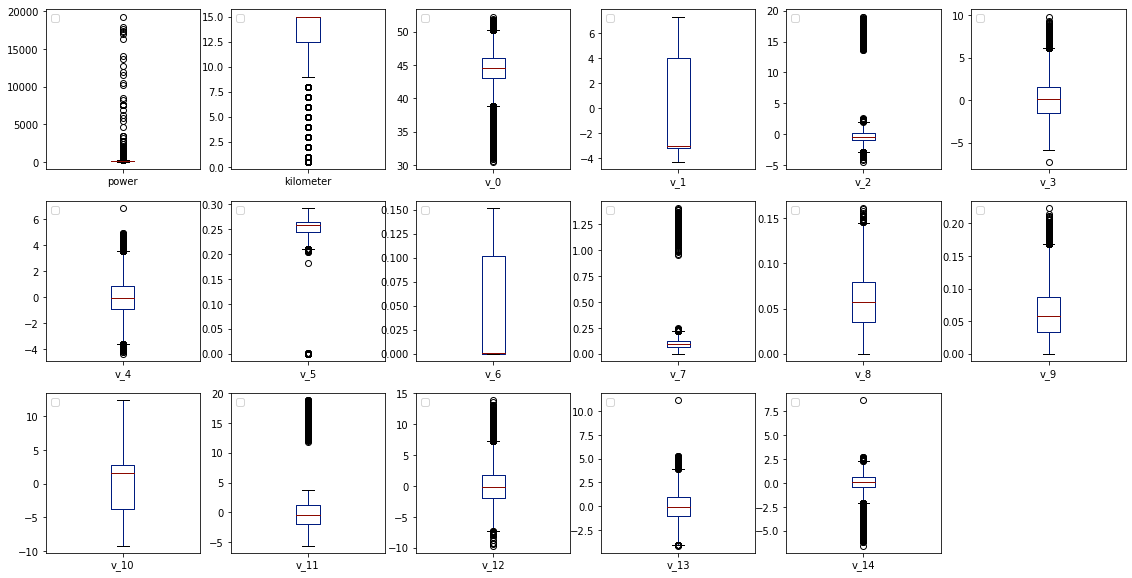

In [53]:
# 数值变量分布
fig = plt.figure(figsize=(20, 10))
plt.subplots_adjust(left=0.15)
for i, c in enumerate(numeric_features):
    ax = fig.add_subplot(3, 6, i + 1)
    plt.style.use('seaborn-dark-palette')
    train[c].plot.box()
    plt.legend(loc='upper left')

* 删除异常值

In [54]:
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """

    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

Delete number is: 963
Now column number is: 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64
Delete number is: 10005
Now column number is: 139032
Description of data less than the lower bound is:
count    10005.000000
mean         2.435632
std          1.268291
min          0.500000
25%          1.000000
50%          3.000000
75%          4.000000
max          4.000000
Name: kilometer, dtype: float64
Description of data larger than the upper bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: kilometer, dtype: float64
Delete numbe

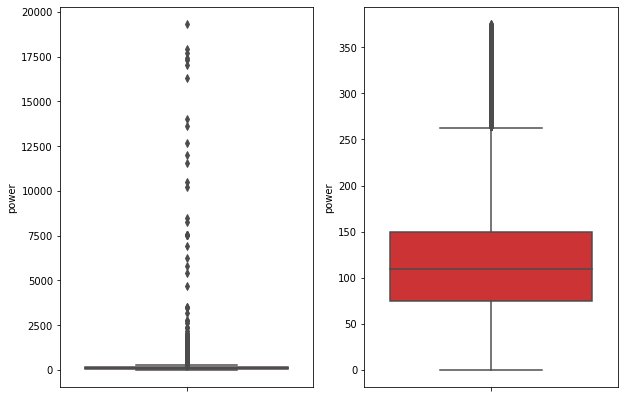

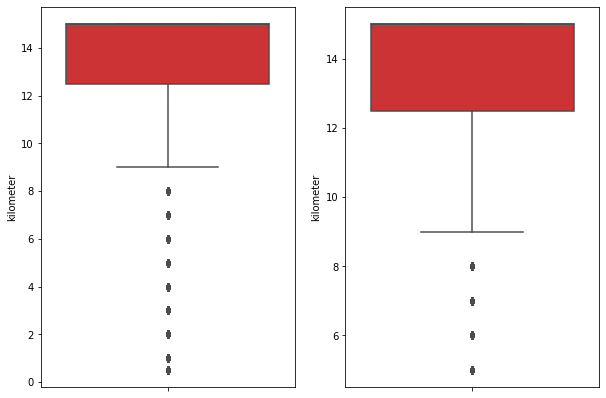

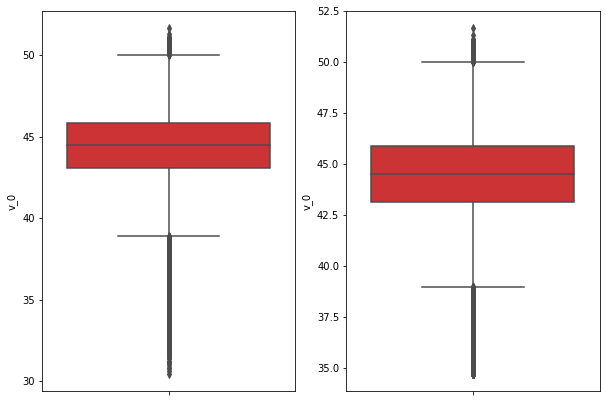

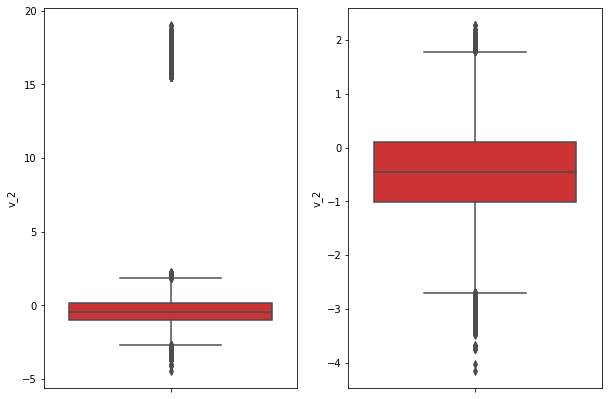

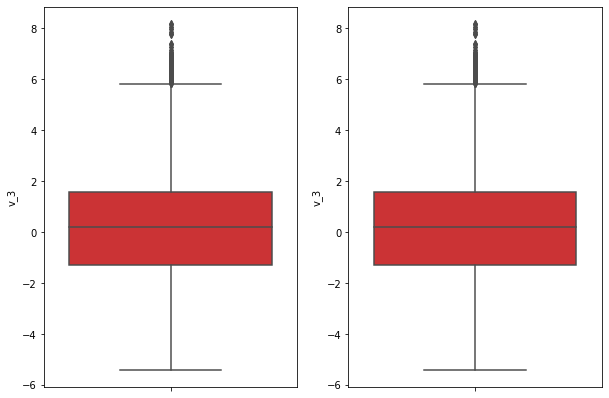

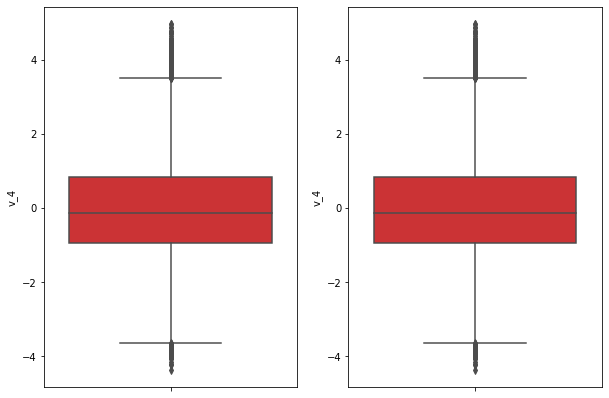

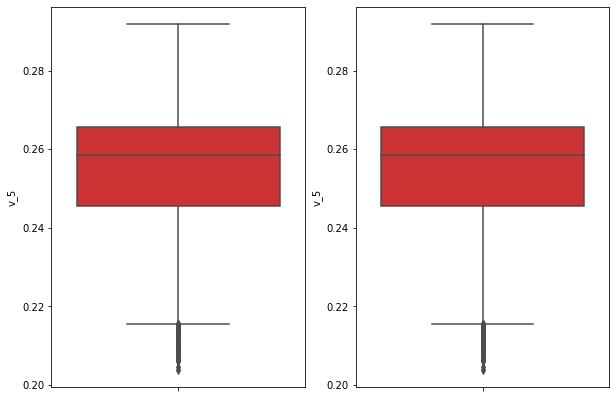

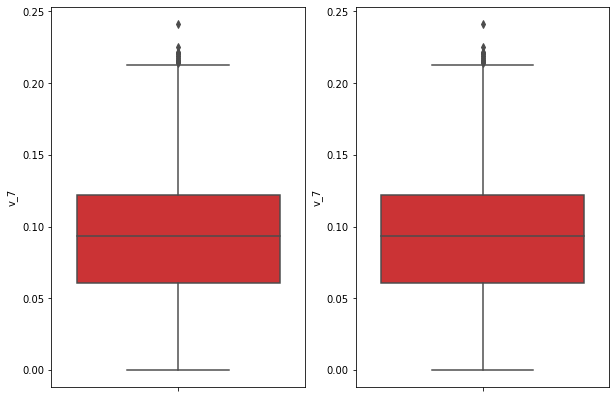

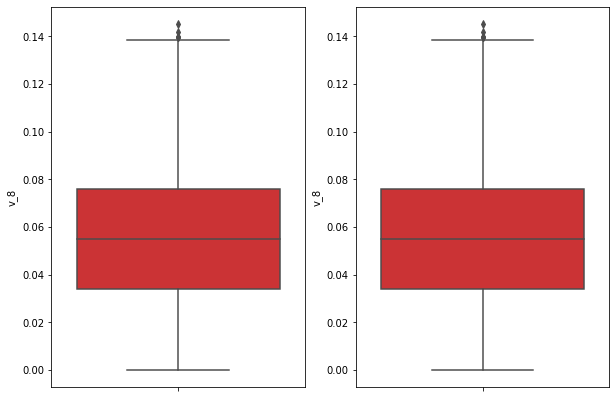

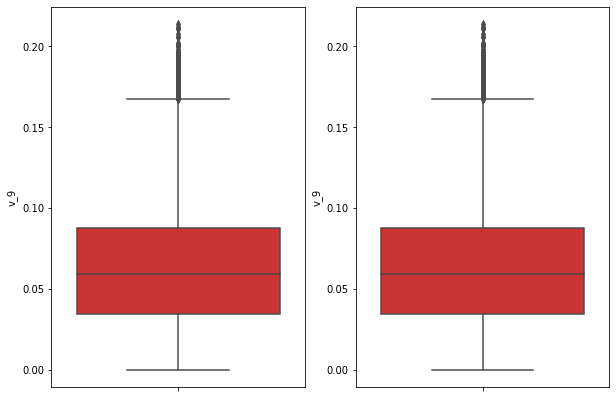

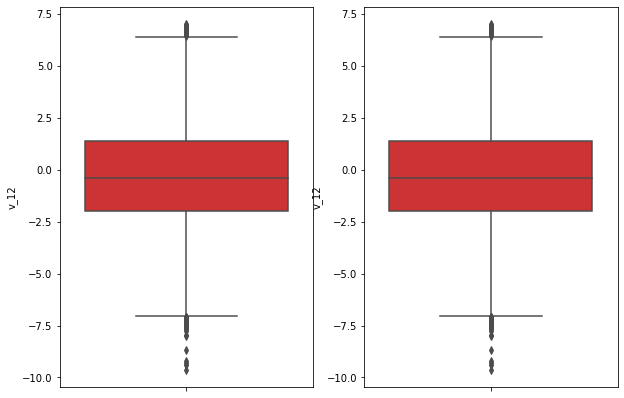

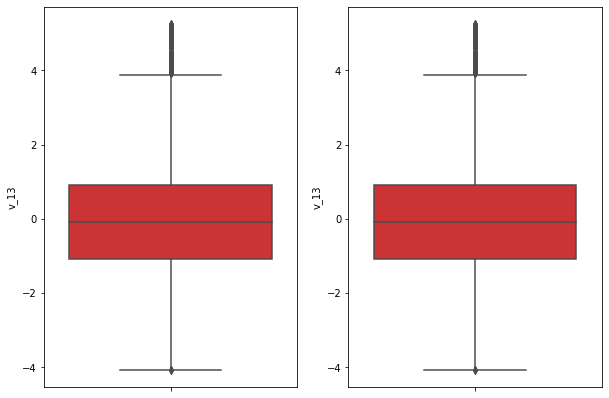

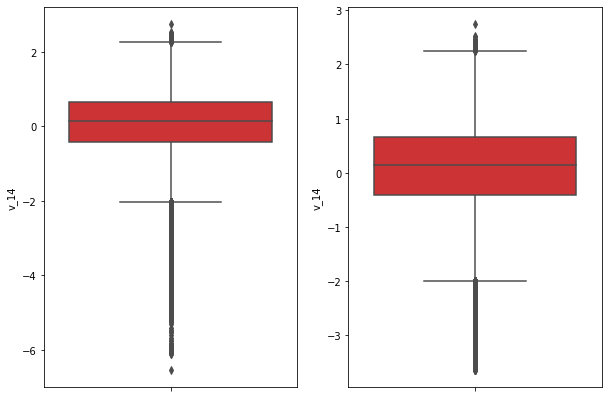

In [55]:
var = ['power', 'kilometer', 'v_0', 'v_2', 'v_3', 'v_4', 'v_5', 'v_7', 'v_8', 'v_9', 'v_12', 'v_13','v_14']
for v in var:
    train = outliers_proc(train, v, scale=3)

* 特征构造

In [56]:
# 训练集和测试集放在一起，方便构造特征
train['train']=1
test['train']=0
data = pd.concat([train, test], ignore_index=True, sort=False)

In [57]:
del data["seller"]
del data["offerType"]
del train["seller"]
del train["offerType"]
del test["seller"]
del test["offerType"]

In [58]:
# 特征工程部分 使用时间/城市信息/
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days
data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])

In [59]:
# 计算某变量的销售统计量
def sale(data, train, var):
    train_gb = train.groupby(var)
    all_info = {}
    for kind, kind_data in train_gb:
        info = {}
        kind_data = kind_data[kind_data['price'] > 0]
        info['{0}_amount'.format(var)] = len(kind_data)
        info['{0}_price_max'.format(var)] = kind_data.price.max()
        info['{0}_price_median'.format(var)] = kind_data.price.median()
        info['{0}_price_min'.format(var)] = kind_data.price.min()
        info['{0}_price_sum'.format(var)] = kind_data.price.sum()
        info['{0}_price_std'.format(var)] = kind_data.price.std()
        info['{0}_price_average'.format(var)] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
        all_info[kind] = info
    brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": var})
    data = data.merge(brand_fe, how='left', on=var)
    return data

In [60]:
data = sale(sale(sale(sale(data, train, 'brand'), train, 'regionCode'), train, 'model'), train, 'gearbox')

In [61]:
# 数据分桶：本部分只有power的取值范围较大 因此只对该变量进行分桶
bin = [i*10 for i in range(31)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)

In [62]:
# 删除原始数据 使用时间 上市日期和注册日期都会与价格有关，这部分选择不删除
data = data.drop(['regionCode'], axis=1)

In [ ]:
# 树模型数据
data.to_csv('data_for_tree.csv', index=0)

* 数值变量处理

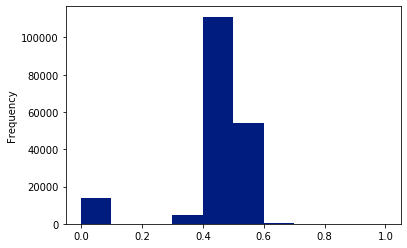

In [64]:
# power对train和test集所有数据取 log，再做归一化
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()
data['power'] = np.log(data['power'] + 1) 
data['power'] = ((data['power'] - np.min(data['power'])) / (np.max(data['power']) - np.min(data['power'])))
data['power'].plot.hist()

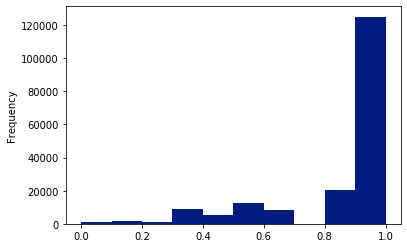

In [65]:
# kilometer直接做归一化
# data['kilometer'].plot.hist()
data['kilometer'] = ((data['kilometer'] - np.min(data['kilometer'])) / 
                        (np.max(data['kilometer']) - np.min(data['kilometer'])))
data['kilometer'].plot.hist()

In [66]:
data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'creatDate',
       'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8',
       'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'train', 'used_time',
       'city', 'brand_amount', 'brand_price_max', 'brand_price_median',
       'brand_price_min', 'brand_price_sum', 'brand_price_std',
       'brand_price_average', 'regionCode_amount', 'regionCode_price_max',
       'regionCode_price_median', 'regionCode_price_min',
       'regionCode_price_sum', 'regionCode_price_std',
       'regionCode_price_average', 'model_amount', 'model_price_max',
       'model_price_median', 'model_price_min', 'model_price_sum',
       'model_price_std', 'model_price_average', 'gearbox_amount',
       'gearbox_price_max', 'gearbox_price_median', 'gearbox_price_min',
       'gearbox_price_sum', 'gearbox_price_std', 'gearbox_price_average',
       'power_bin'

In [67]:
def max_min(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

data.iloc[:, 31:-1] = data.iloc[:, 31:-1].apply(lambda x : max_min(x))

In [68]:
# 对类别特征进行 OneEncoder
data = pd.get_dummies(data, columns=['model', 'brand', 'bodyType', 'fuelType',
                                     'gearbox', 'notRepairedDamage', 'power_bin'])

In [69]:
print(data.shape)
data.columns

(184193, 391)


Index(['SaleID', 'name', 'regDate', 'power', 'kilometer', 'creatDate', 'price',
       'v_0', 'v_1', 'v_2',
       ...
       'power_bin_20.0', 'power_bin_21.0', 'power_bin_22.0', 'power_bin_23.0',
       'power_bin_24.0', 'power_bin_25.0', 'power_bin_26.0', 'power_bin_27.0',
       'power_bin_28.0', 'power_bin_29.0'],
      dtype='object', length=391)

In [70]:
# 回归算法-神经网络可
data.to_csv('data_for_lr.csv', index=0)

* 特征筛选

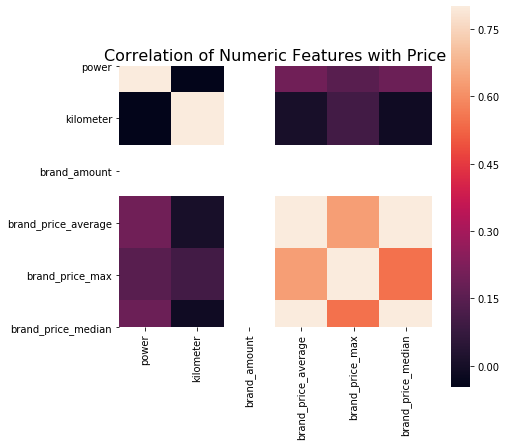

In [90]:
# 当然也可以直接看图
data_numeric = data[['power', 'kilometer', 'brand_amount', 'brand_price_average', 
                     'brand_price_max', 'brand_price_median']]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)